In [1]:
import numpy as np
import sys
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

%matplotlib inline
import glob
import warnings
warnings.filterwarnings('ignore')
from pprint import pprint
import importlib

import numpy as np
from scipy import interpolate
from scipy.interpolate import RegularGridInterpolator

In [2]:
#download the ECCO grid file

from ecco_download import *

ecco_podaac_download(ShortName="ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                    StartDate="2000-01-09",EndDate="2000-01-14",download_root_dir=None,\
                    n_workers=6,force_redownload=False)

created download directory /home/m267zhou/Downloads/ECCO_V4r4_PODAAC/ECCO_L4_GEOMETRY_LLC0090GRID_V4R4
{'ShortName': 'ECCO_L4_GEOMETRY_LLC0090GRID_V4R4', 'temporal': '2000-01-09,2000-01-14'}

Total number of matching granules: 1

GRID_GEOMETRY_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading
DL Progress: 100%|########################| 1/1 [00:00<00:00, 10459.61it/s]

total downloaded: 0.0 Mb
avg download speed: 0.0 Mb/s


In [3]:
# download file (granule) containing 2000 velocities,
# to default path ~/Downloads/ECCO_V4r4_PODAAC/
vel_monthly_shortname = "ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4"
ecco_podaac_download(ShortName=vel_monthly_shortname,\
                    StartDate="2000-01-02",EndDate="2000-12-31",download_root_dir=None,\
                    n_workers=6,force_redownload=False)

created download directory /home/m267zhou/Downloads/ECCO_V4r4_PODAAC/ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4
{'ShortName': 'ECCO_L4_OCEAN_VEL_LLC0090GRID_MONTHLY_V4R4', 'temporal': '2000-01-02,2000-12-31'}

Total number of matching granules: 12

OCEAN_VELOCITY_mon_mean_2000-01_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-02_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-04_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-06_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-03_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-05_ECCO_V4r4_native_llc0090.nc already exists, and force=False, not re-downloading

OCEAN_VELOCITY_mon_mean_2000-07_ECCO_V4r4_native_llc0090.nc already exist

In [4]:
## Import the ecco_v4_py library into Python
## =========================================
##    If ecco_v4_py is not installed in your local Python library, 
##    tell Python where to find it.  The example below adds
##    ecco_v4_py to the user's path if it is stored in the folder
##    ECCOv4-py under the user's home directory

from os.path import join,expanduser
user_home_dir = expanduser('~')

sys.path.append(join(user_home_dir,'ECCOv4-py'))

import ecco_v4_py as ecco

In [5]:
## Set top-level file directory for the ECCO NetCDF files
## =================================================================

## currently set to ~/Downloads/ECCO_V4r4_PODAAC, 
## the default if ecco_podaac_download was used to download dataset granules
ECCO_dir = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC')

In [6]:
## Load the model grid
ecco_grid = xr.open_dataset(glob.glob(join(ECCO_dir,'*GEOMETRY*','*.nc'))[0])

In [7]:
## Load vector fields
ecco_vars = xr.open_mfdataset(join(ECCO_dir,'*OCEAN*VEL*MONTHLY*','*_2000-*.nc'))

ecco_ds = []

## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_ds = xr.merge((ecco_grid , ecco_vars)).load()

In [8]:
vel_34_lat = np.zeros((50, 66-50))

In [9]:
#at 33.5 degree latitude (YC[something, 64], max = 33.521168, min = 33.521168)
#something: [50, 66)
#longitude from -77.5 to -62.5 degree
for depth in range (0,50):
    for lon in range(50, 66):
        xfld = ecco_ds.UVEL.isel(k=depth, time=0)
        yfld = ecco_ds.VVEL.isel(k=depth, time=0)
        # Compute the zonal and meridional vector components of UVEL and VVEL
        VEL_E, VEL_N  = ecco.vector_calc.UEVNfromUXVY(xfld, yfld, ecco_ds)  
        vel_34_lat[depth, lon-50] = VEL_N.isel(tile=10)[lon,64].values

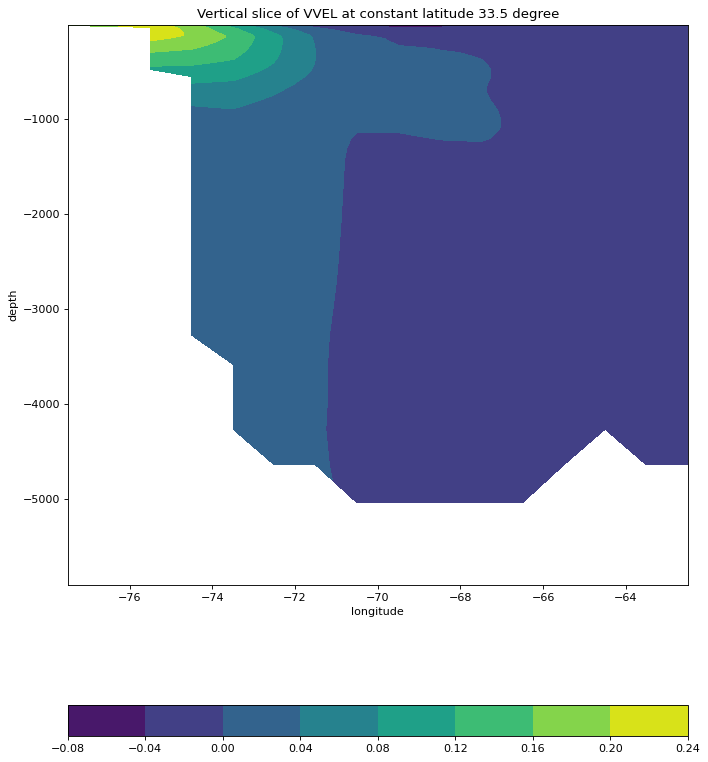

In [10]:
#plot vertical slice at 33.5 degree latitude
plt.figure(figsize=(10,13), dpi= 80);

xfld = ecco_ds.UVEL.isel(k=0, time=0)
yfld = ecco_ds.VVEL.isel(k=0, time=0)

# Compute the zonal and meridional vector components of UVEL and VVEL
VEL_E, VEL_N  = ecco.vector_calc.UEVNfromUXVY(xfld, yfld, ecco_ds) 

#get longitude and depth array
lon_ran = VEL_N.isel(tile=10).XC[50:66,64].values
dep_ran = np.array(ecco_grid.Z[0:50])

plt.contourf(lon_ran, dep_ran, vel_34_lat)
plt.title('Vertical slice of VVEL at constant latitude 33.5 degree');
plt.xlabel('longitude')
plt.ylabel('depth')
plt.colorbar(orientation='horizontal');